## 목차
1. 데이터 준비  
    [1-1. 라이브러리 불러오기](#라이브러리-불러오기)  
    [1-2. 데이터 불러오기](#데이터-불러오기--전처리)  
2. 가설 검증
    [2-1. 노쇼 수 가설 검증](#가설--특정-시간대요일에-노쇼-물품이-많을-것이다)
3. GPT
    [3-1. GPT description 최소 글자수](#description-최소-글자수-판단하기)

# 라이브러리 불러오기

In [36]:
import pickle
import pandas as pd
import os
import openai
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 불러오기 & 전처리

In [32]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'preprocessing')
data_file_path = os.path.join(data_directory, 'description_complete2.csv')
df = pd.read_csv(data_file_path)

# 가설 : 특정 시간대/요일에 노쇼 물품이 많을 것이다.

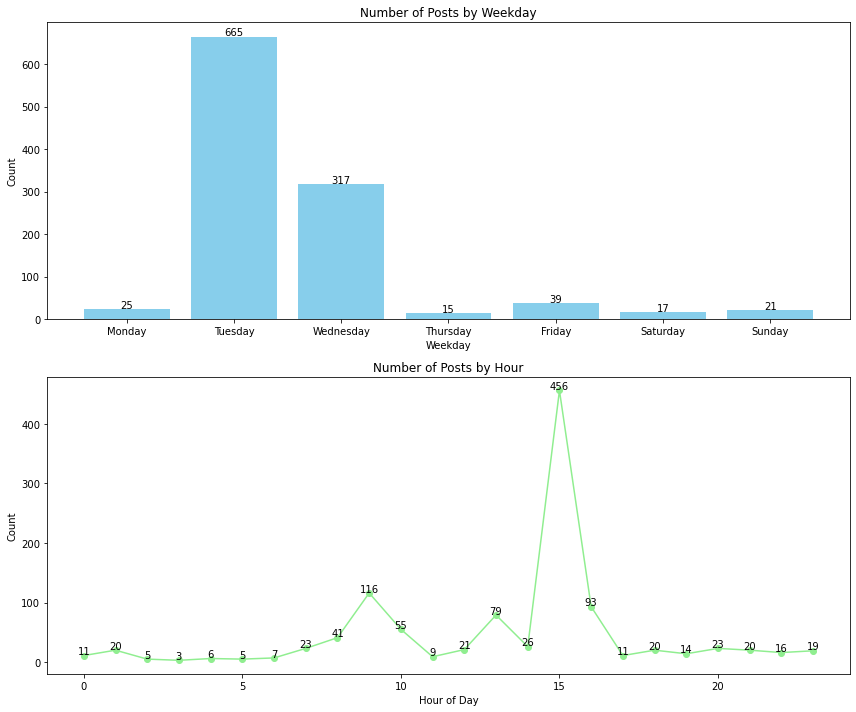

In [12]:
# 'post_time'에서 요일과 시간 추출
df['post_time'] = pd.to_datetime(df['post_time'])
df['weekday'] = df['post_time'].dt.day_name()  # 요일 이름
df['hour'] = df['post_time'].dt.hour  # 시간 (0-23)

# 요일 순서 설정
ordered_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['weekday'], categories=ordered_weekdays, ordered=True)

# 요일별 갯수 집계
weekday_counts = df['weekday'].value_counts().sort_index()

# 시간대별 갯수 집계
hour_counts = df['hour'].value_counts().sort_index()

# 그래프 설정
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# 요일별 갯수 시각화 (막대 그래프)
axs[0].bar(weekday_counts.index, weekday_counts.values, color='skyblue')
axs[0].set_title('Number of Posts by Weekday')
axs[0].set_xlabel('Weekday')
axs[0].set_ylabel('Count')

# 개수 표시
for i, count in enumerate(weekday_counts):
    axs[0].text(i, count + 2, str(count), ha='center', fontsize=10)

# 시간대별 갯수 시각화 (선 그래프)
axs[1].plot(hour_counts.index, hour_counts.values, marker='o', color='lightgreen')
axs[1].set_title('Number of Posts by Hour')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Count')

# 개수 표시
for i, count in enumerate(hour_counts):
    axs[1].text(i, count + 2, str(count), ha='center', fontsize=10)

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()
plt.show()

# description 최소 글자수 판단하기

In [37]:
# description의 글자 수를 계산하는 열 추가
df['description_length'] = df['description'].apply(len)

# expiration_stdate 이후의 열 목록
generated_columns = df.columns[16:]  # expiration_stdate 이후의 필드들

# 각 행의 null 값 개수를 계산하여 null_count 열 추가
df['null_count'] = df[generated_columns].isnull().sum(axis=1)

In [40]:
# 상관계수 계산 
correlation = df['description_length'].corr(df['null_count'])
print(f"Description Length와 Null Count 간의 상관계수: {correlation}")

Description Length와 Null Count 간의 상관계수: -0.12301267366081256


In [41]:
# 설명 변수: Description Length
X = df['description_length']

# 종속 변수: Null Count
y = df['null_count']

# 상수 추가
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X)
result = model.fit()

# 결과 출력
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             null_count   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     29.36
Date:                   목, 10 10 2024   Prob (F-statistic):           6.76e-08
Time:                        23:02:47   Log-Likelihood:                -4364.9
No. Observations:                1913   AIC:                             8734.
Df Residuals:                    1911   BIC:                             8745.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.2522      0

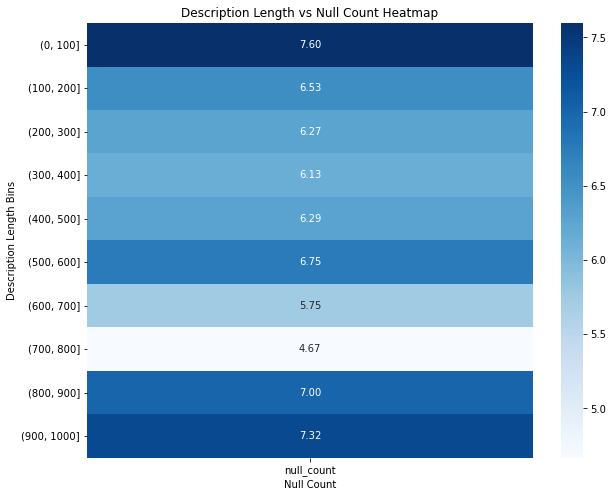

In [44]:
# Description Length를 범위로 나눔 (예: 10자 단위로 구분)
df['description_bin'] = pd.cut(df['description_length'], bins=range(0, df['description_length'].max() + 10, 100))

# description_bin별로 null_count 평균을 계산
heatmap_data = df.groupby('description_bin')['null_count'].mean().reset_index()

# 피벗 테이블 형태로 데이터 변환 (필요시 사용)
heatmap_data_pivot = heatmap_data.pivot_table(index='description_bin', values='null_count')

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='Blues', fmt='.2f')

plt.title('Description Length vs Null Count Heatmap')
plt.ylabel('Description Length Bins')
plt.xlabel('Null Count')

plt.show()

C:\Users\sera\AppData\Local\Temp\ipykernel_324\3882653905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['description_bin'] = pd.cut(df_filtered['description_length'], bins=range(0, 210, 10))


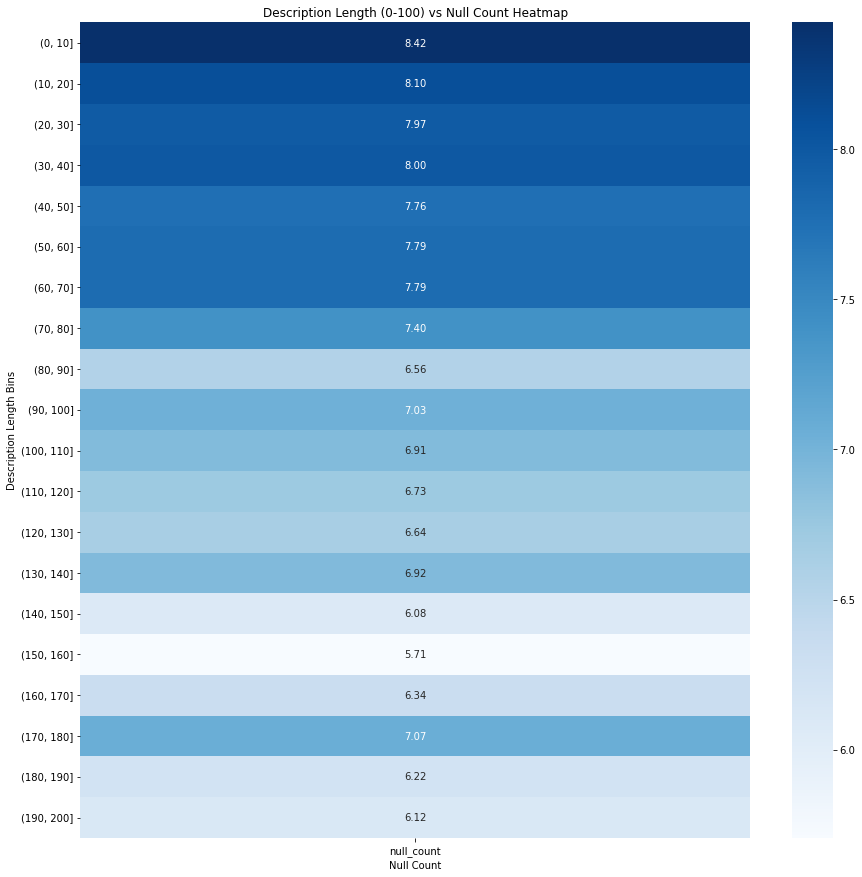

In [55]:
# description_length가 0에서 100 사이인 데이터만 필터링
df_filtered = df[(df['description_length'] >= 0) & (df['description_length'] <= 200)]

# Description Length를 10 단위로 구분
df_filtered['description_bin'] = pd.cut(df_filtered['description_length'], bins=range(0, 210, 10))

# 각 구간(description_bin)별로 null_count의 평균을 계산
heatmap_data = df_filtered.groupby('description_bin')['null_count'].mean().reset_index()

# 피벗 테이블 형태로 변환
heatmap_data_pivot = heatmap_data.pivot_table(index='description_bin', values='null_count')

# 히트맵 그리기
plt.figure(figsize=(15, 15))
sns.heatmap(heatmap_data_pivot, annot=True, cmap='Blues', fmt='.2f')

plt.title('Description Length (0-100) vs Null Count Heatmap')
plt.ylabel('Description Length Bins')
plt.xlabel('Null Count')

plt.show()